In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import copy
import sys
from importlib import reload
from typing import Dict, List, Tuple

import addict
import celeri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import collections
from tqdm.notebook import tqdm

plt.rcParams[
    "text.usetex"
] = False  # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Western North America example
command_file_name = "../data/command/western_north_america_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# Adjust mesh values
meshes[0].smoothing_weight = 1e16
meshes[0].top_slip_rate_constraint = 0
meshes[0].bot_slip_rate_constraint = 0
meshes[0].side_slip_rate_constraint = 0

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2024-01-02 17:41:45.040 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2024-01-02 17:41:45.041 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2024-01-02-17-41-45
2024-01-02 17:41:45.042 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2024-01-02-17-41-45/2024-01-02-17-41-45.log
2024-01-02 17:41:45.042 | INFO     | celeri.celeri:read_data:129 - Reading data files
2024-01-02 17:41:45.079 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2024-01-02 17:41:45.081 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2024-01-02 17:41:45.082 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2024-01-02 17:41:45.144 | SUCCESS  | celeri.celeri:read_data:266 - Read: ../data/mesh/cascadia.msh
2024-01-02 17:41:45.147 | SUCCESS  | celeri.celeri:read_data:302 - Read: ../data/station/western_north_america_station.csv
2024-01-02 17:41:45.149 | INFO     | celeri.celeri:read_data:317 - No mogi_file_name
2024-01-02 17:41:45.150 | INFO     | celeri.celeri:read_data:339 - No sar_file_name


# Get elastic operators and TDE smoothing operators

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-01-02 17:41:45.890 | INFO     | celeri.celeri:get_elastic_operators:1525 - Using precomputed elastic operators


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-01-02 17:41:46.513 | INFO     | celeri.celeri:get_slip_rate_constraints:1164 - Found 1 slip rate constraints
2024-01-02 17:41:46.516 | INFO     | celeri.celeri:get_slip_rate_constraints:1167 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Plot input data

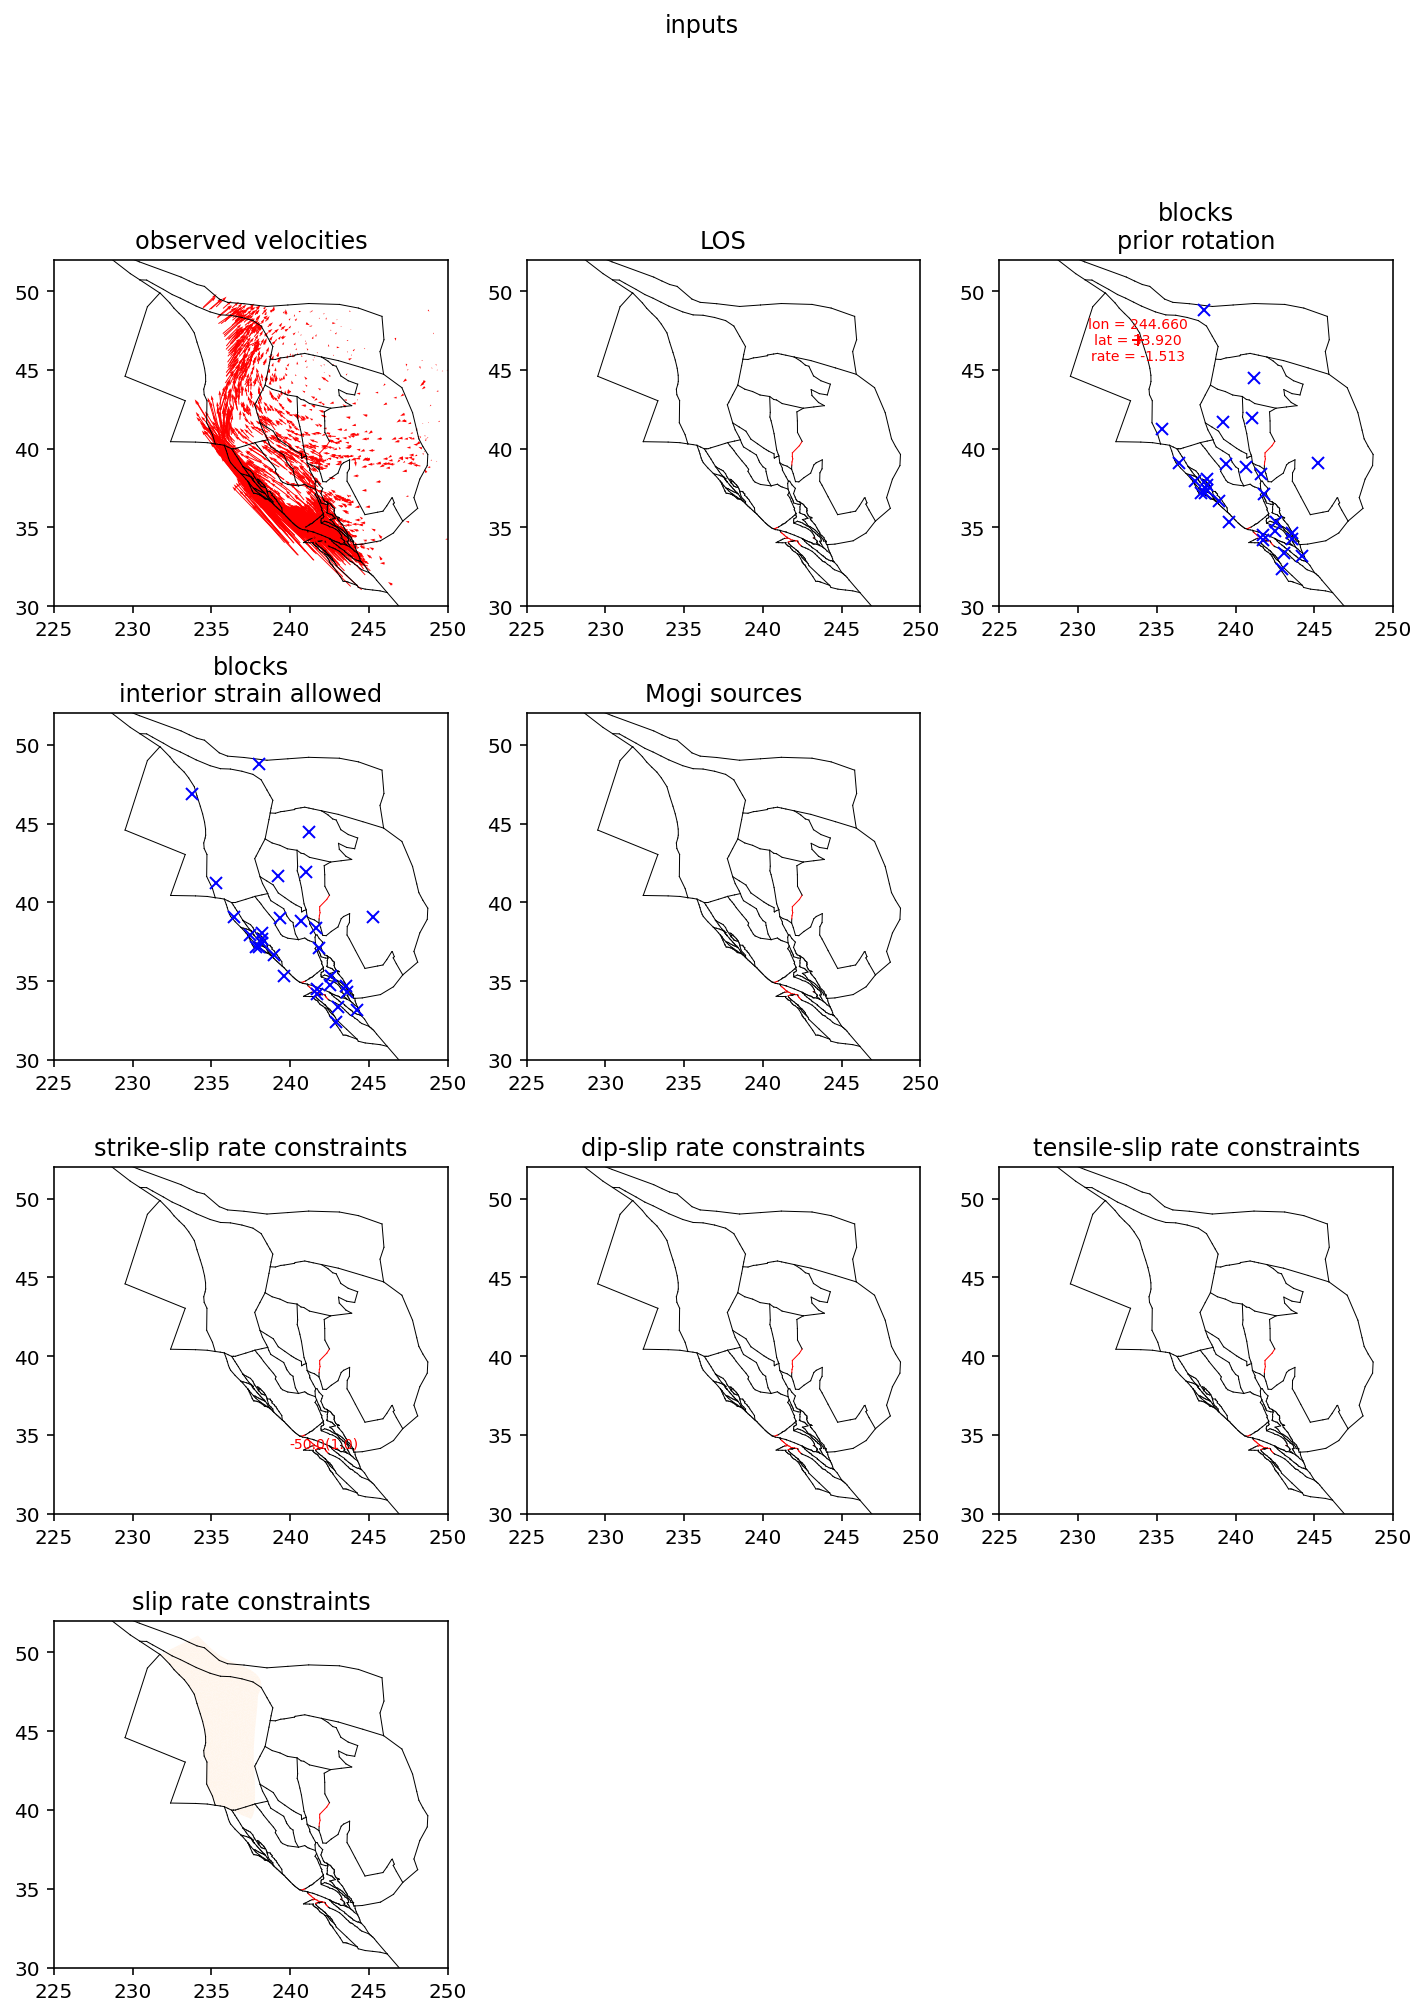

2024-01-02 17:41:50.357 | SUCCESS  | celeri.celeri:plot_input_summary:4085 - Wrote figures../runs/2024-01-02-17-41-45/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [8]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

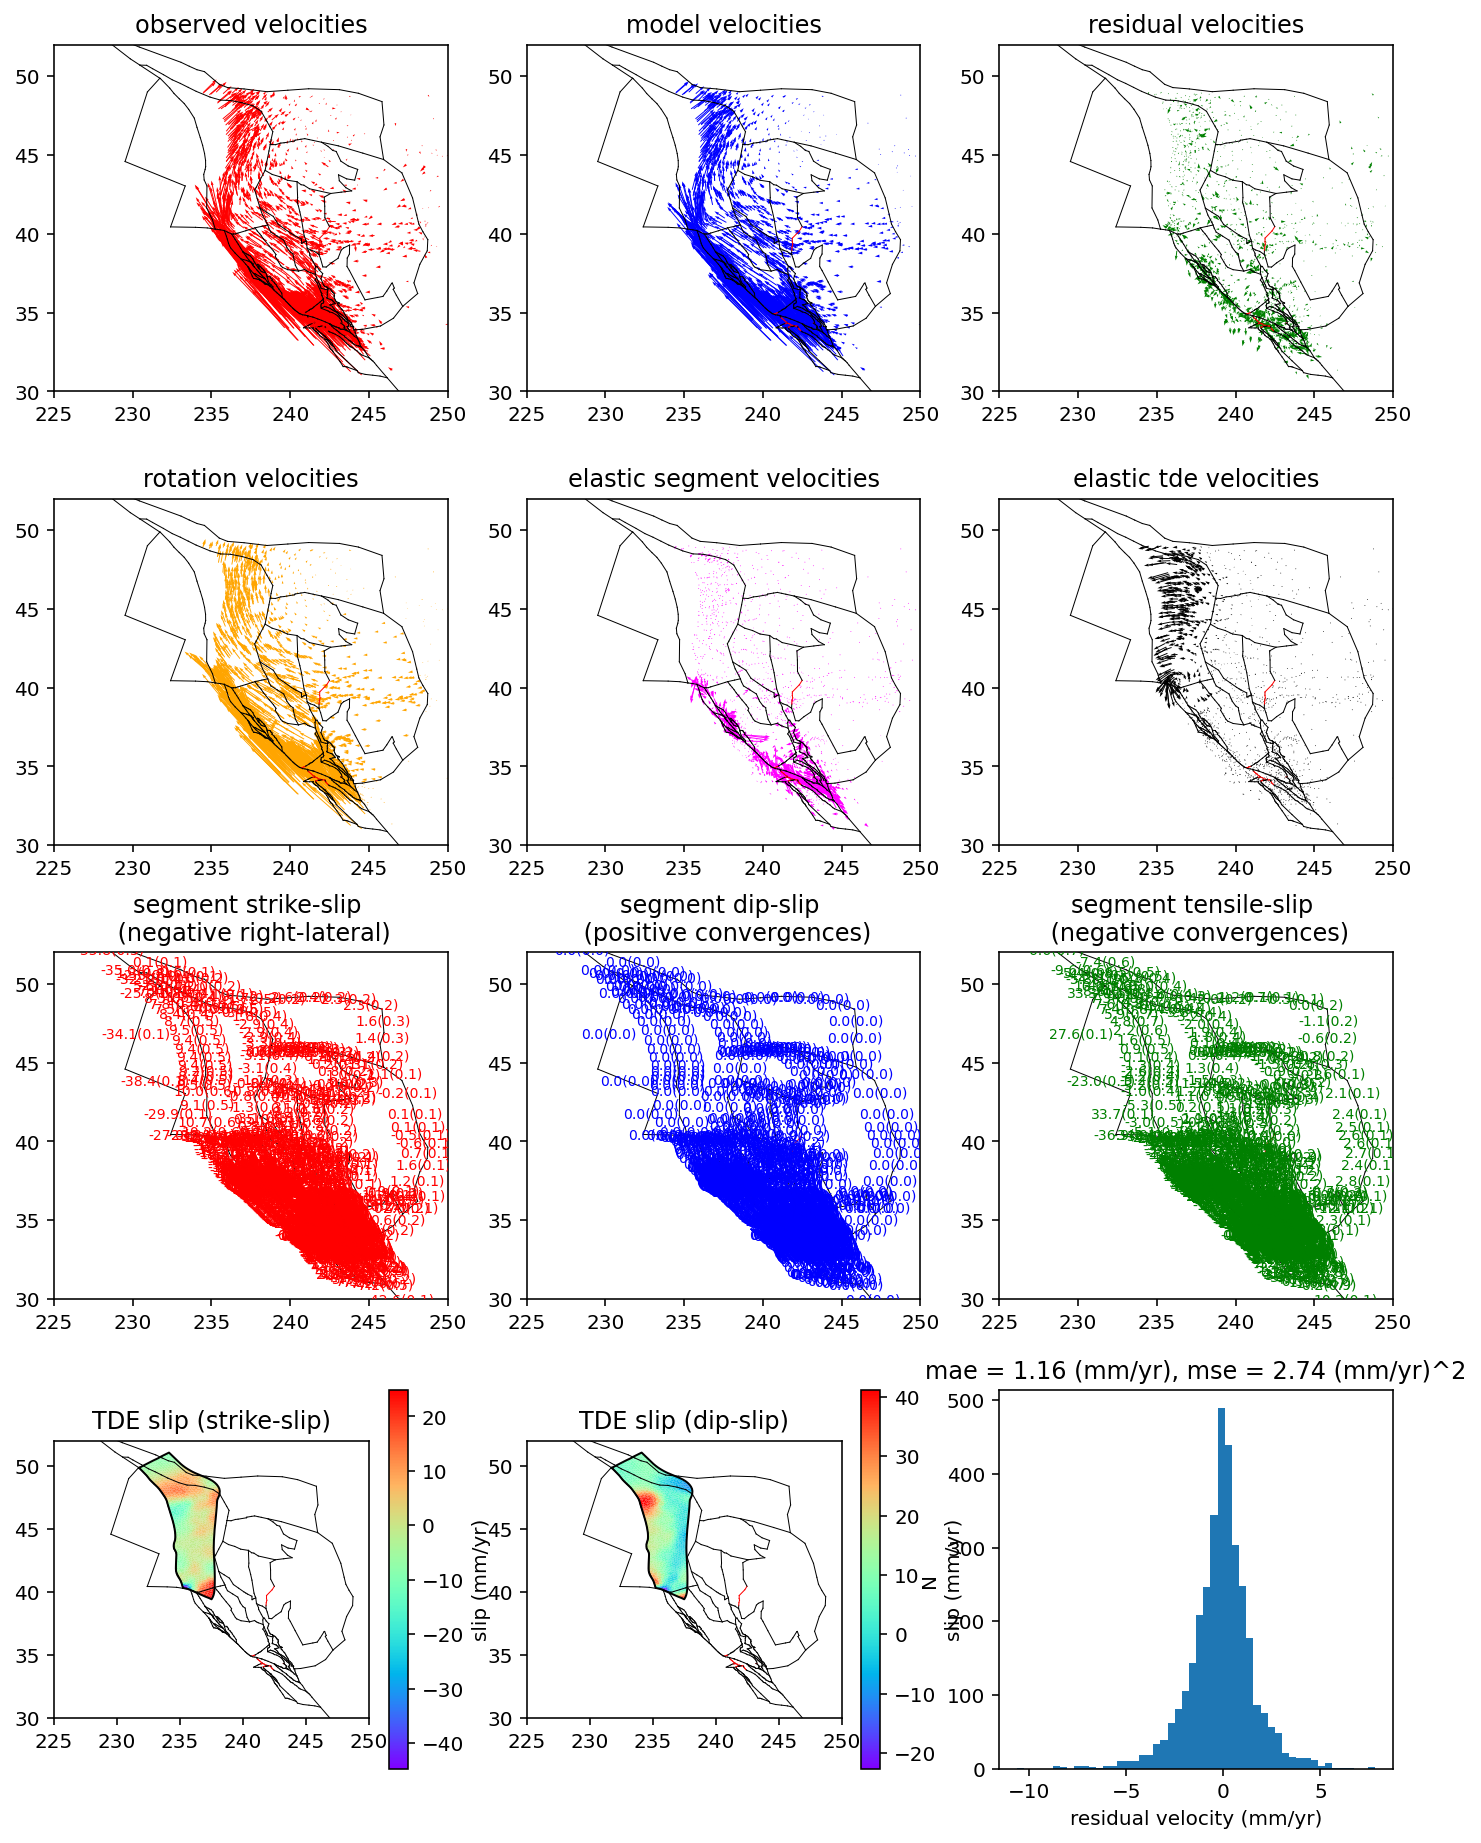

2024-01-02 17:41:59.900 | SUCCESS  | celeri.celeri:plot_estimation_summary:4585 - Wrote figures../runs/2024-01-02-17-41-45/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [9]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Start of synthetic slip distribution test

In [10]:
def plot_mesh(mesh, slip_values, ax):
    """
    Plots a colored mesh where the x and y values correspond to longitude and depth respectively and
    and the color represents the slip value.

    Inputs:
        mesh: a mesh object
        slip_values: [float] an array specifying the `slip` value of each triangle
        ax: a matplotlib axis object

    Return:
        a PolyCollection object
    """
    x_coords = mesh.meshio_object.points[:, 0]  # lon
    y_coords = mesh.meshio_object.points[:, 1]  # lat
    vertex_array = np.asarray(mesh.verts)

    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]

    pc = collections.PolyCollection(
        verts,
        edgecolor="k",
        cmap="turbo",
        linewidth=0.1,
        alpha=1.0,
    )
    pc.set_array(slip_values)
    pc.set_clim([-30, 30])

    if not ax:
        ax = plt.gca()
    ax.add_collection(pc)
    ax.autoscale()
    return pc

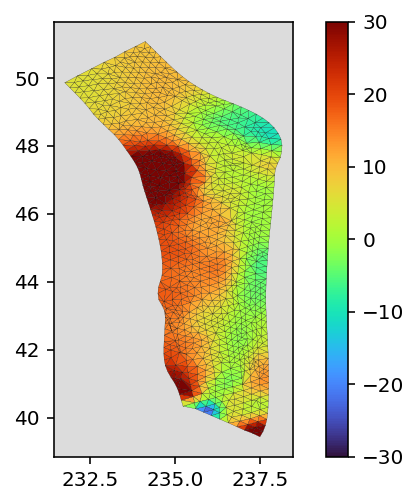

In [11]:
pc = plot_mesh(meshes[0], estimation.tde_dip_slip_rates, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

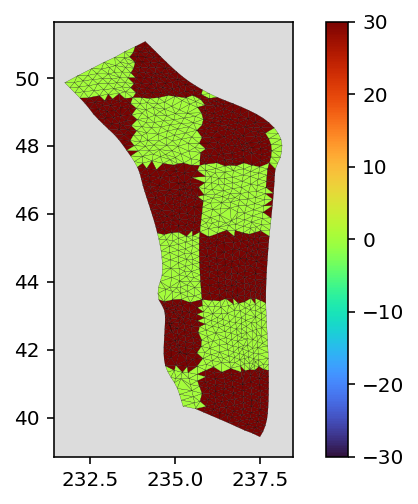

In [12]:
def set_slip_values(mesh, slip_values, rect, fill_value):
    """
    Modifies the slip value of the mesh in a given rectangular section.

    Inputs:
        mesh: a mesh object
        slip_values: [float] an array specifying the `slip` value of each triangle
        rect: [[x0, y0], [x1, y1]] an array or tuple containing the lower and upper bounds (e.g. [28, 30])
        fill_value: float the value that will be used to override the mask's range

    Return:
        a slip array

    """
    [[lon0, depth0], [lon1, depth1]] = rect

    if depth0 > depth1:
        depth0, depth1 = depth1, depth0

    x_coords = mesh.meshio_object.points[:, 0]  # lon
    y_coords = mesh.meshio_object.points[:, 2]  # depth
    vertex_array = np.asarray(mesh.verts)
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    n_triangles = len(vertex_array)

    for i in range(n_triangles):
        lon_centroid = mesh.centroids[i, 0]
        depth_centroid = mesh.centroids[i, 1]

        if lon0 <= lon_centroid < lon1 and depth0 <= depth_centroid < depth1:
            slip_values[i] = fill_value

    return slip_values


def checkerboard_slip_values(
    mesh,
    lon_start,
    lon_end,
    lon_step,
    depth_start,
    depth_end,
    depth_step,
    slip_value_1,
    slip_value_2,
):
    """
    Creates a checkerboard pattern of the mesh for a given step in longitude and depth, and for a couple of slip values.

    Inputs:
        mesh: a mesh object
        lon_start: min longitude of the mesh
        lon_end: max longitude of the mesh
        lon_step: space covered by a rectangle along the lon axis -> (km/111)
        depth_start: min depth of the mesh
        depth_end: max depth of the mesh
        depth_step: space (in km) covered by a rectangle along the depth axis
        slip_value_1: [float] an array specifying the `slip` value of each triangle in a certain rectangle
        slip_value_1: [float] an array specifying the `slip` value of each triangle in the following rectangle

    Return:
        a slip array

    """
    n_triangles = len(mesh.verts)
    slip_values = np.random.uniform(low=0, high=24, size=n_triangles)
    row = 0
    depth = depth_start

    while depth_start <= depth <= depth_end:
        col = 0
        lon = lon_start

        while lon_start <= lon <= lon_end:
            # select colors based on parity
            # slip_value = slip_value_1 if (row + col) % 2 == 0 else slip_value_2
            if (row + col) % 2 == 0:
                slip_value = slip_value_1
            else:
                slip_value = slip_value_2

            # set `slip_value` on current rectangle
            slip_values = set_slip_values(
                mesh,
                slip_values,
                [[lon, depth], [lon + lon_step, depth + depth_step]],
                slip_value,
            )

            # increment longitude iterators
            col += 1
            lon += lon_step

        # increment depth iterators
        row += 1
        depth += depth_step
    return slip_values


slip_values = checkerboard_slip_values(
    meshes[0],
    lon_start=meshes[0].x_perimeter.min(),
    lon_end=meshes[0].x_perimeter.max(),
    lon_step=2,
    depth_start=meshes[0].y_perimeter.min(),
    depth_end=meshes[0].y_perimeter.max(),
    depth_step=2,
    slip_value_1=30,
    slip_value_2=0,
)

pc = plot_mesh(meshes[0], slip_values, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

# Generate synthic interseismic slip distribution on Cascadia

In [13]:
# Replace inferred Cascadia rates with synthetic slip
synthetic_state_vector = np.copy(estimation.state_vector)
synthetic_data_vector = np.copy(estimation.data_vector)
synthetic_state_vector[
    3 * index.n_blocks + 1 : 3 * index.n_blocks + 2 * index.n_tde_total : 2
] = 0
synthetic_state_vector[
    3 * index.n_blocks : 3 * index.n_blocks + 2 * index.n_tde_total : 2
] = slip_values

# Forward velocities
synthetic_predictions = estimation.operator @ synthetic_state_vector
synthetic_data_vector[0 : 2 * index.n_stations : 2] = synthetic_predictions[
    0 : 2 * index.n_stations : 2
]

# Unbounded (classic) block model solve with synthetic slip deficit distribution

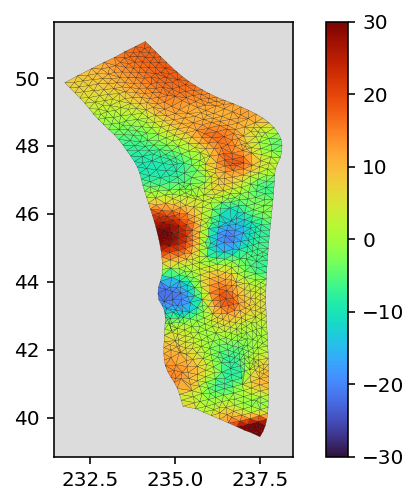

In [14]:
estimated_synthetic_state_vector_unconstrained = (
    (estimation.state_covariance_matrix @ estimation.operator.T)
    * estimation.weighting_vector
    @ synthetic_data_vector
)

tde_rates_unconstrained = estimated_synthetic_state_vector_unconstrained[
    3 * index.n_blocks : 3 * index.n_blocks + 2 * index.n_tde_total
]
tde_ss_rates_unconstrained = tde_rates_unconstrained[0::2]
tde_ds_rates_unconstrained = tde_rates_unconstrained[1::2]

pc = plot_mesh(meshes[0], tde_ds_rates_unconstrained, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

# Bounded (`lsq_linear`) block model solve with synthetic slip deficit distribution

In [15]:
lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# Strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# Dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

# Experiment: constrainted least squares
- The idea is to constrain TDE slip rates in some region

In [16]:
lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# Strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# Dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

from scipy.optimize import lsq_linear

# Non-linear solver (bounded)
res = lsq_linear(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    synthetic_data_vector * np.sqrt(estimation.weighting_vector),
    bounds=(lower_bound, upper_bound),
    verbose=1,
)

The maximum number of iterations is exceeded.
Number of iterations 100, initial cost 2.1350e+04, final cost 1.0200e+04, first-order optimality 4.68e+08.


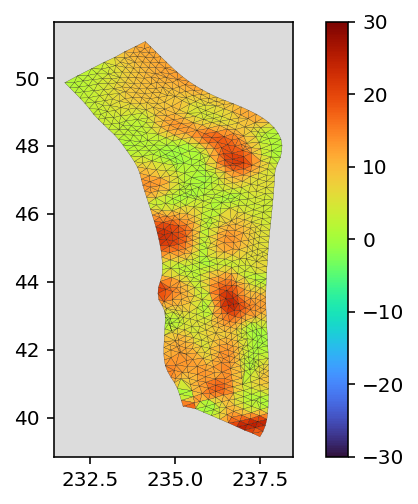

In [17]:
tde_rates_constrained = res.x[
    3 * index.n_blocks : 3 * index.n_blocks + 2 * index.n_tde_total
]
tde_ss_rates_constrained = tde_rates_constrained[0::2]
tde_ds_rates_constrained = tde_rates_constrained[1::2]

pc = plot_mesh(meshes[0], tde_ds_rates_constrained, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

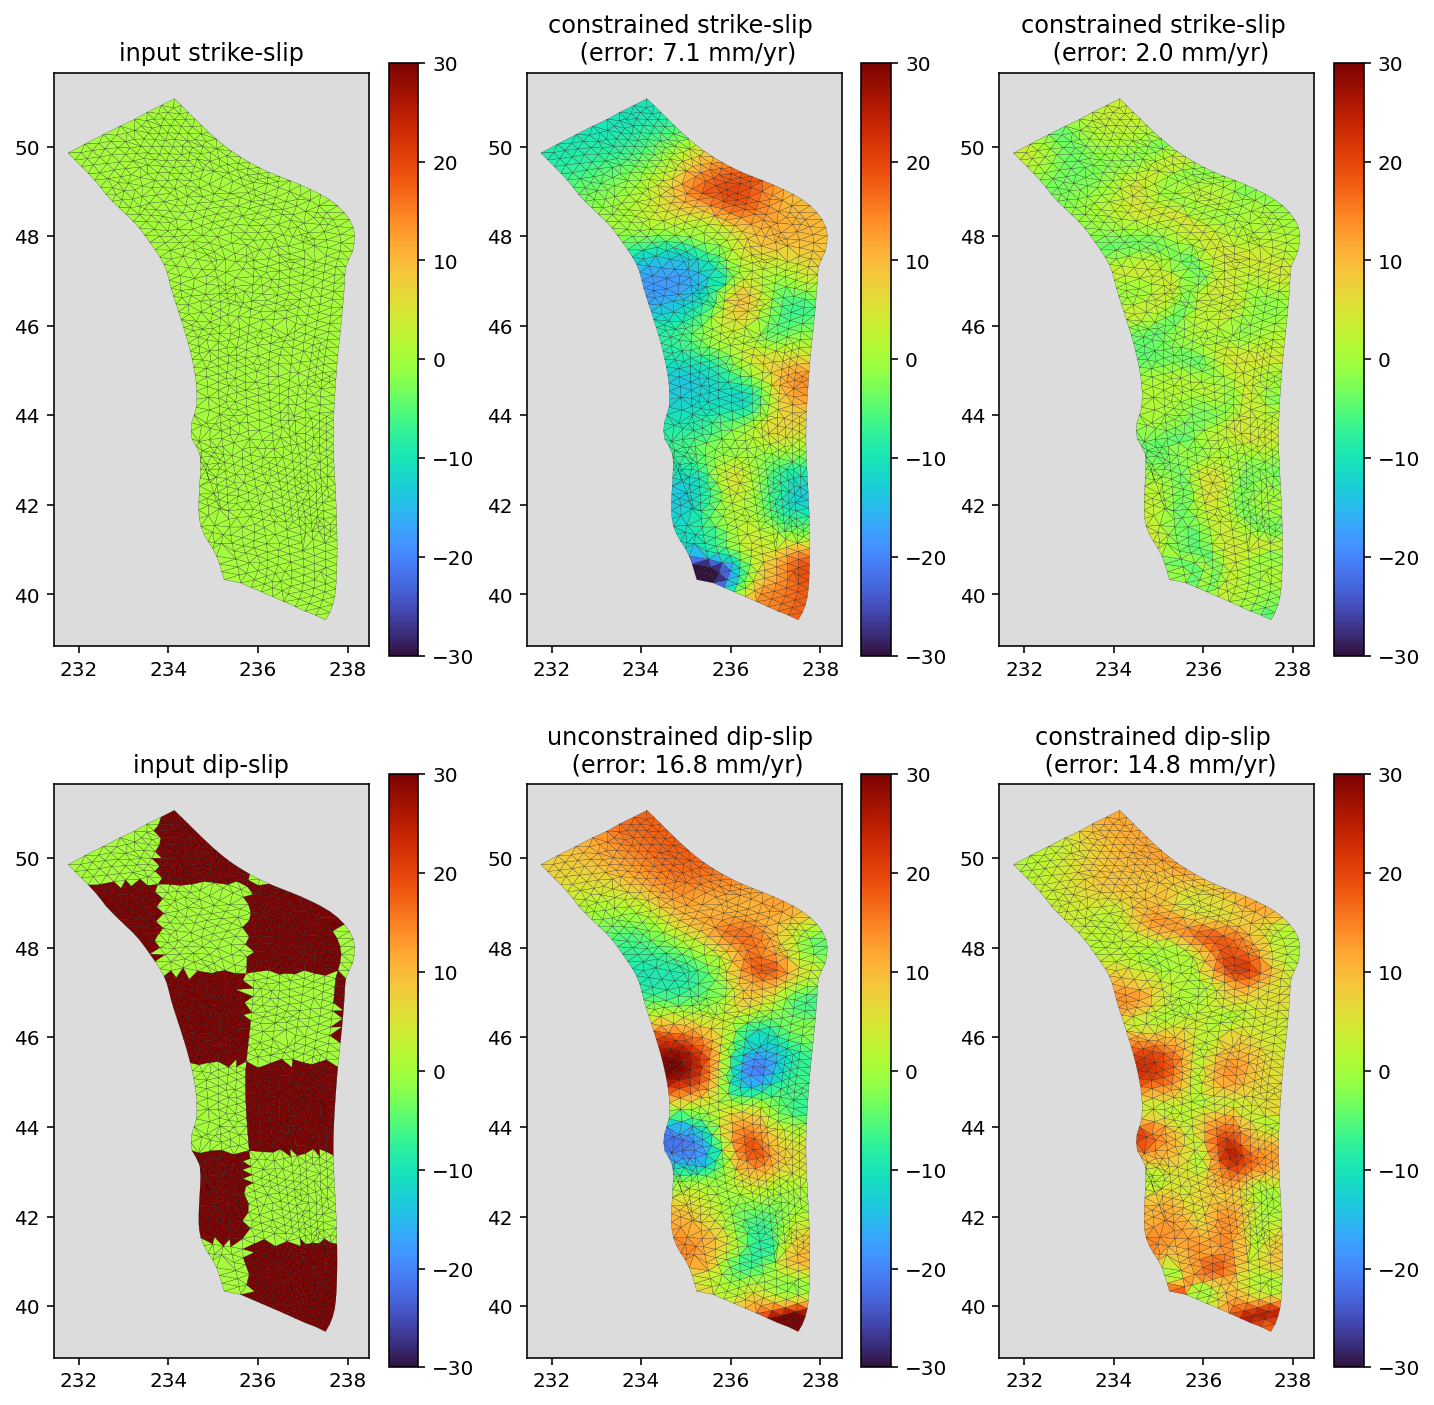

In [19]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 3, 1)
plt.title("input strike-slip")
pc = plot_mesh(meshes[0], np.zeros_like(tde_ss_rates_unconstrained), plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

plt.subplot(2, 3, 2)
misfit = (
    np.sum(np.abs(tde_ss_rates_unconstrained - np.zeros_like(slip_values)))
    / meshes[0].n_tde
)
plt.title(f"constrained strike-slip \n (error: {misfit:.1f} mm/yr)")
pc = plot_mesh(meshes[0], tde_ss_rates_unconstrained, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

plt.subplot(2, 3, 3)
misfit = (
    np.sum(np.abs(tde_ss_rates_constrained - np.zeros_like(slip_values)))
    / meshes[0].n_tde
)
plt.title(f"constrained strike-slip \n (error: {misfit:.1f} mm/yr)")
pc = plot_mesh(meshes[0], tde_ss_rates_constrained, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")


plt.subplot(2, 3, 4)
plt.title("input dip-slip")
pc = plot_mesh(meshes[0], slip_values, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

plt.subplot(2, 3, 5)
misfit = np.sum(np.abs(tde_ds_rates_unconstrained - slip_values)) / meshes[0].n_tde
plt.title(f"unconstrained dip-slip \n (error: {misfit:.1f} mm/yr)")
pc = plot_mesh(meshes[0], tde_ds_rates_unconstrained, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

plt.subplot(2, 3, 6)
misfit = np.sum(np.abs(tde_ds_rates_constrained - slip_values)) / meshes[0].n_tde
plt.title(f"constrained dip-slip \n (error: {misfit:.1f} mm/yr)")
pc = plot_mesh(meshes[0], tde_ds_rates_constrained, plt.gca())
plt.colorbar(pc)
plt.gca().set_facecolor("gainsboro")
plt.gca().set_aspect("equal")

plt.savefig("cascadia_resolution.pdf")
plt.show()